In [4]:
!pip install xgboost scikit-learn pandas matplotlib seaborn joblib --quiet

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, RocCurveDisplay

In [6]:
from zipfile import ZipFile
from google.colab import files

uploaded = files.upload()  # Upload the ZIP file

with ZipFile(next(iter(uploaded)), 'r') as zip_ref:
    zip_ref.extractall('data')

Saving Telco-Customer-Churn.zip to Telco-Customer-Churn.zip


In [7]:
# Load CSV inside extracted folder (adjust filename if needed)
df = pd.read_csv('data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
# Drop customerID and missing TotalCharges
df.drop('customerID', axis=1, inplace=True)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df.dropna(inplace=True)

# Encode target
df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1})

# Label encode object columns
le = LabelEncoder()
for col in df.select_dtypes(include='object'):
    df[col] = le.fit_transform(df[col])

# Split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [9]:
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'GradientBoosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

param_grids = {
    'LogisticRegression': {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'DecisionTree': {
        'max_depth': [None, 5, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    },
    'XGBoost': {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5]
    }
}

In [10]:
best_models = {}
model_reports = {}

for name in models:
    print(f"🔍 Tuning {name}...")
    search = RandomizedSearchCV(models[name], param_distributions=param_grids[name],
                                n_iter=5, cv=3, scoring='f1', n_jobs=-1, verbose=1, random_state=42)
    search.fit(X_train, y_train)
    best_models[name] = search.best_estimator_

    # Save tuning results
    results_df = pd.DataFrame(search.cv_results_).sort_values('mean_test_score', ascending=False)
    results_df.to_csv(f"{name}_tuning_results.csv", index=False)

    # Evaluation
    y_pred = search.best_estimator_.predict(X_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    model_reports[name] = report

    print(f"✅ Best {name} Params: {search.best_params_}")
    print(classification_report(y_test, y_pred))

🔍 Tuning LogisticRegression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 4 is smaller than n_iter=5. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


✅ Best LogisticRegression Params: {'solver': 'liblinear', 'penalty': 'l2', 'C': 10}
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1033
           1       0.62      0.56      0.59       374

    accuracy                           0.79      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.79      0.79      1407

🔍 Tuning DecisionTree...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Best DecisionTree Params: {'min_samples_split': 10, 'max_depth': 5}
              precision    recall  f1-score   support

           0       0.83      0.88      0.86      1033
           1       0.61      0.50      0.55       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407

🔍 Tuning RandomForest...
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Best RandomForest Pa

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [08:37:38] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Best XGBoost Params: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.64      0.52      0.57       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



In [11]:
# Confusion Matrices
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig(f'{name}_confusion_matrix.png', dpi=300)
    plt.close()

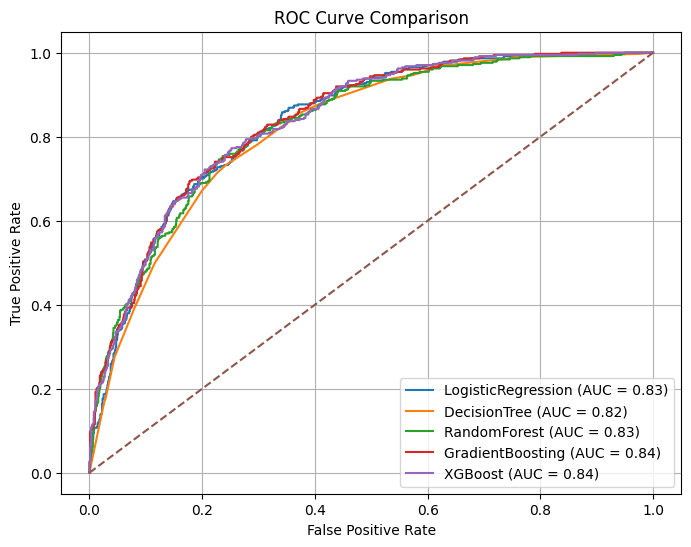

In [12]:
# ROC Curve Comparison
plt.figure(figsize=(8, 6))
for name, model in best_models.items():
    y_probs = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid(True)
plt.savefig("roc_comparison.png", dpi=300)
plt.show()

<ipython-input-13-62ad2d0f1159>:21: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-13-62ad2d0f1159>:23: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.savefig("f1_score_comparison.png", dpi=300)


<Figure size 1200x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


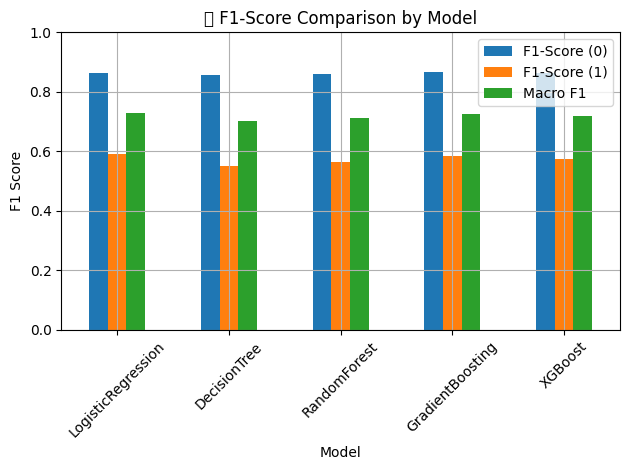

In [13]:
f1_summary = []

for name, report in model_reports.items():
    f1_summary.append({
        'Model': name,
        'F1-Score (0)': report['0']['f1-score'],
        'F1-Score (1)': report['1']['f1-score'],
        'Macro F1': report['macro avg']['f1-score']
    })

results_df = pd.DataFrame(f1_summary)
results_df.to_csv("model_f1_scores.csv", index=False)

# Bar Plot
plt.figure(figsize=(12, 6))
results_df.set_index('Model')[['F1-Score (0)', 'F1-Score (1)', 'Macro F1']].plot(kind='bar')
plt.title('🔍 F1-Score Comparison by Model')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.savefig("f1_score_comparison.png", dpi=300)
plt.show()

In [14]:
# Save models and test sets
for name, model in best_models.items():
    joblib.dump(model, f"{name}_model.pkl")

joblib.dump(X_test, "X_test.pkl")
joblib.dump(y_test, "y_test.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [15]:
import pandas as pd

# Assuming you already have 'model_reports' and 'best_models' from hyperparameter tuning step
model_summary = []

for model_name, report in model_reports.items():
    model_summary.append({
        'Model': model_name,
        'Accuracy': report['accuracy'],
        'Precision (0)': report['0']['precision'],
        'Recall (0)': report['0']['recall'],
        'F1-Score (0)': report['0']['f1-score'],
        'Precision (1)': report['1']['precision'],
        'Recall (1)': report['1']['recall'],
        'F1-Score (1)': report['1']['f1-score'],
        'Macro F1': report['macro avg']['f1-score']
    })

results_df = pd.DataFrame(model_summary)
results_df.to_csv("model_metrics_summary.csv", index=False)
results_df.head()

,Model,Accuracy,Precision (0),Recall (0),F1-Score (0),Precision (1),Recall (1),F1-Score (1),Macro F1
0,LogisticRegression,0.793888,0.847521,0.877057,0.862036,0.624260,0.564171,0.592697,0.727366
1,DecisionTree,0.781805,0.830000,0.883833,0.856071,0.609121,0.500000,0.549192,0.702632
2,RandomForest,0.788913,0.835155,0.887706,0.860629,0.624595,0.516043,0.565154,0.712891
3,GradientBoosting,0.797441,0.840619,0.893514,0.866260,0.644013,0.532086,0.582723,0.724492
4,XGBoost,0.794598,0.836957,0.894482,0.864764,0.640264,0.518717,0.573117,0.718940


In [16]:
results_df = pd.read_csv("model_metrics_summary.csv")

In [17]:
import pandas as pd

# Load model results from CSV (if already saved)
results_df = pd.read_csv("model_metrics_summary.csv")  # Change path if needed

<ipython-input-18-2c900dcaac4b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Accuracy', palette='Set2')
<ipython-input-18-2c900dcaac4b>:6: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-18-2c900dcaac4b>:8: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig("accuracy_comparison.png", dpi=300, bbox_inches='tight')
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


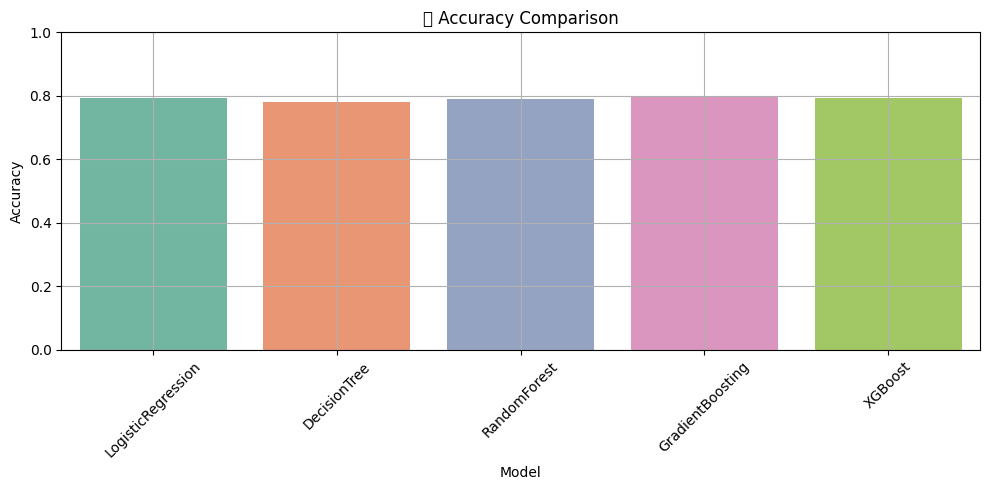

In [18]:
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df, x='Model', y='Accuracy', palette='Set2')
plt.title('✅ Accuracy Comparison')
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.savefig("accuracy_comparison.png", dpi=300, bbox_inches='tight')
plt.show()

<ipython-input-19-f94f6e96d652>:10: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-19-f94f6e96d652>:11: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("dashboard_class1_metrics.png", dpi=300)


<Figure size 1200x600 with 0 Axes>

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


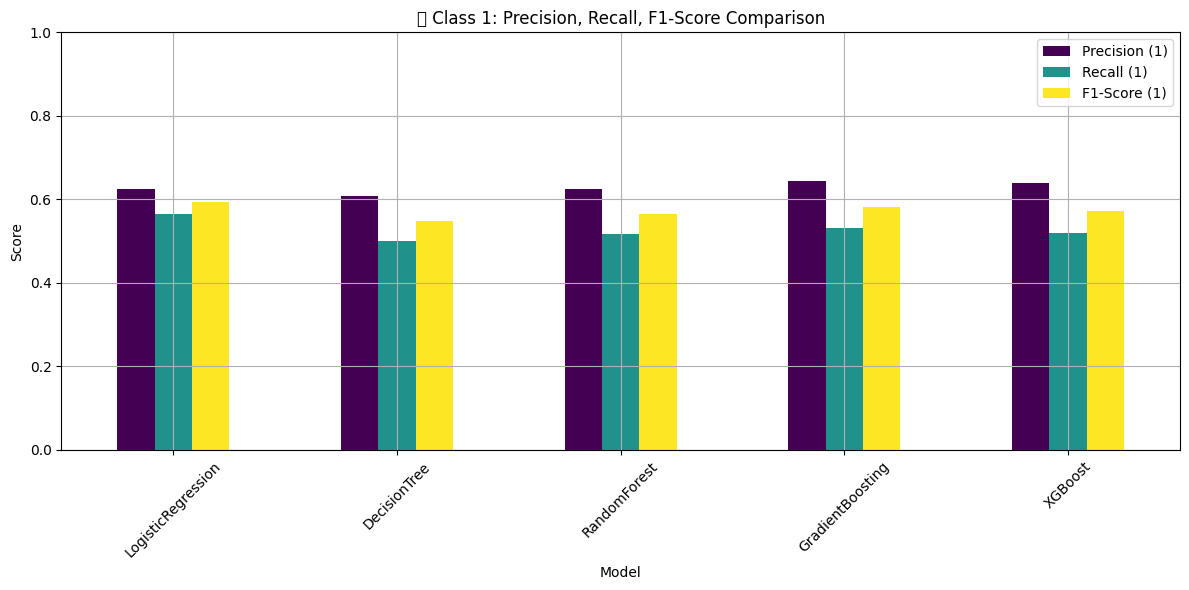

In [19]:
plt.figure(figsize=(12, 6))
metrics_1 = results_df[['Model', 'Precision (1)', 'Recall (1)', 'F1-Score (1)']]
metrics_1.set_index("Model").plot(kind="bar", figsize=(12, 6), colormap="viridis")

plt.title("📊 Class 1: Precision, Recall, F1-Score Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.ylim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.savefig("dashboard_class1_metrics.png", dpi=300)
plt.show()

<ipython-input-20-258475da955c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x='Model', y='Macro F1', palette='coolwarm')


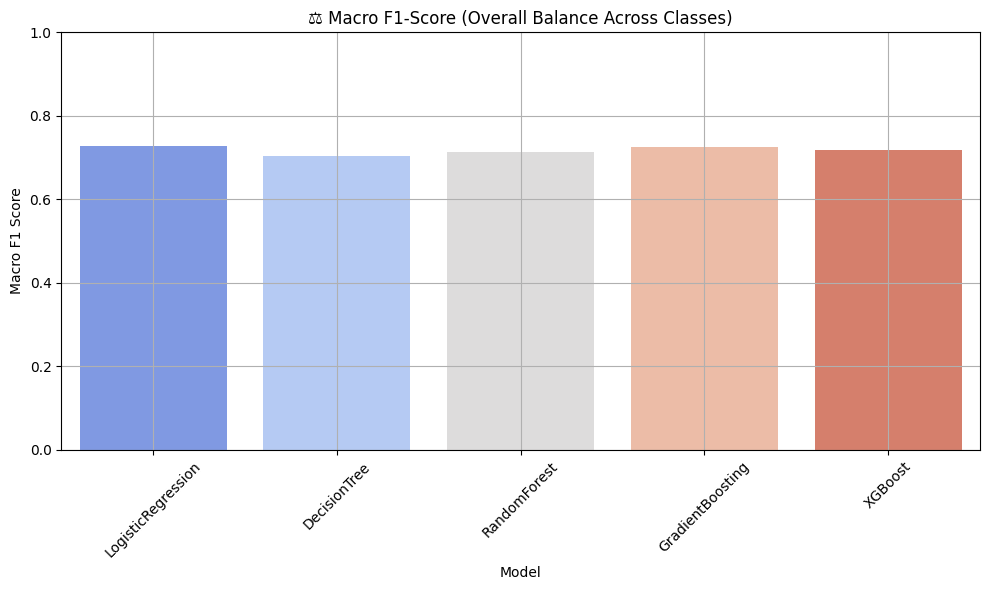

In [20]:
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Model', y='Macro F1', palette='coolwarm')
plt.title("⚖️ Macro F1-Score (Overall Balance Across Classes)")
plt.ylim(0, 1)
plt.ylabel("Macro F1 Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("dashboard_macro_f1.png", dpi=300)
plt.show()

In [21]:
best_model = results_df.sort_values("Macro F1", ascending=False).iloc[0]
print(f"🏆 Best Overall Model Based on Macro F1-Score: {best_model['Model']} ({best_model['Macro F1']:.3f})")

# You can also show class-specific winners
best_f1_class1 = results_df.sort_values("F1-Score (1)", ascending=False).iloc[0]
print(f"📌 Best for Class 1: {best_f1_class1['Model']} with F1-Score = {best_f1_class1['F1-Score (1)']:.3f}")

🏆 Best Overall Model Based on Macro F1-Score: LogisticRegression (0.727)
📌 Best for Class 1: LogisticRegression with F1-Score = 0.593
